# FFDI and Thresholding

code is setup to process the intial bias_input_data into FFDI and thresholding.

The FFDI code uses the zarr stores of the individual simulations which requires the rechunking

Thresholding uses the FFDI files of the individual simulations


In [1]:
import sys
import os

import intake
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [2]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client()
client

2024-06-25 23:09:10,742 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-25 23:09:10,747 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-25 23:09:10,754 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/47631/proxy/8787/status,
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/47631/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37017,Workers: 32
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/47631/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35775,Total threads: 1
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/47631/proxy/38047/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37421,


2024-06-25 23:13:14,759 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-FFDI-da75c656f985e6a8d2f90f3c7c67e13d' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x1498c60c7ac0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x149725539240>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x1498c60c7ac0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(arra

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
catalogue_path = '/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path + '/*ssp370*.json'))
print(len(mRuns))

13


In [5]:
def extract_model_info(filepath):
    filename = filepath.split('/')[-1]  # Get the filename from the full path
    filename_no_ext = filename.split('.')[0]  # Remove the file extension
    parts = filename_no_ext.split('_')  # Split filename by underscores
#    print(parts)
    RCM=parts[1]
    GCM=parts[2]
    
    # Extract model name
    model_name = filename_no_ext
    extension = filename.split('.')[-1]  # Get the extension
    
    match = '_'.join(parts[1:3])  # Extract match (e.g., EC-Earth3_ssp370_r1i1p1f1)
    pathway = parts[3]  # Extract model (e.g., ssp370)
    ensemble = parts[4]  # Extract ensemble (e.g., r1i1p1f1)
    
    return [model_name, extension], RCM, GCM, ensemble, pathway

In [6]:
def calculate_ffdi(pra, tasmaxa, pr_annual, hursmina, sfcWindmaxa):
    KBDI = keetch_byram_drought_index(pra, tasmaxa, pr_annual)
    DF = griffiths_drought_factor(pra, KBDI)
    FFDI = mcarthur_forest_fire_danger_index(DF, tasmaxa, hursmina, sfcWindmaxa)
    return FFDI.to_dataset(name='FFDI')

In [7]:
def process_threshold(data, time_dim, syear, eyear, var, period):
# first set time slice
    start=str(syear)+'-01-01'
    end=str(eyear)+'-12-31'
    nyear=eyear-syear+1; inyear=1./nyear
    data = data.sel(**{time_dim: slice(start, end)}).persist() # use file chunking .persist()
    print(f"Processing period {period}")
# days over key thresholds (days/yr)
#    d100 = data > 100 ; d100.groupby(time_dim.year).mean
    d3=(data > 100 ).groupby('time.year').sum('time').to_dataset(name='days100')
    d2=(data > 75 ).groupby('time.year').sum('time').to_dataset(name='days75')
    d1=(data > 50 ).groupby('time.year').sum('time').to_dataset(name='days50')
#    d3 = (data > 100).sum('time').to_dataset(name='days100') *inyear
#    d2 = (data > 75).sum('time').to_dataset(name='days75') *inyear
#    d1 = (data > 50).sum('time').to_dataset(name='days50') *inyear
    dss=xr.merge([d1,d2,d3]) 
    return dss

In [8]:
def process_GWL_levels(model_name, GCM, ensemble, pathway, ffdi_data):
    CMIP='CMIP6'
    GWL_levels = ['1.2', '1.5', '2.0', '3.0']
#    GWL_levels = ['1.2']
    for GWL in GWL_levels:
        print(f"Processing GWL {GWL} for model: {GCM}, ensemble: {ensemble}, pathway: {pathway}")
        try:
            start, end = gwl.get_GWL_syear_eyear(CMIP, GCM, ensemble, pathway,GWL= GWL)
        except:
            print(f"No GWL data found for {GWL}")
            continue
        ffdi_data=xr.open_zarr('/g/data/ia39/ncra/fire2/'+model_name+'_FFDI.zarr')
        d4 = process_threshold(ffdi_data.FFDI, 'time', start, end, 'FFDI', GWL)
        output_path = f'/g/data/ia39/ncra/fire/{model_name}_GWL{GWL}_ffdi_thresholda.nc'
        print(f"Saved  to {output_path}")
        d4.to_netcdf(output_path)
    return d4

In [ ]:
%%time
# iterate through all modesl
for mindex, file in enumerate(mRuns):
    print(file)
    model_name, RCM, GCM, ensemble, pathway = extract_model_info(file)
    var='FFDI'  # not used
    if mindex != 1:         #this model failed to convert
#    if mindex == 1:         #this model failed to convert
        print (mindex)
        d4=process_GWL_levels(model_name[0],GCM,ensemble,pathway,var)

    
print("Processing of all catalogues is complete.")
#client.close()

/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day.json
0
Processing GWL 1.2 for model: ACCESS-CM2, ensemble: r4i1p1f1, pathway: ssp370
/g/data/xv83/rxm599/acs/gwls
Processing period 1.2
Saved  to /g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi_thresholda.nc
Processing GWL 1.5 for model: ACCESS-CM2, ensemble: r4i1p1f1, pathway: ssp370
/g/data/xv83/rxm599/acs/gwls
Processing period 1.5
Saved  to /g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.5_ffdi_thresholda.nc
Processing GWL 2.0 for model: ACCESS-CM2, ensemble: r4i1p1f1, pathway: ssp370
/g/data/xv83/rxm599/acs/gwls
Processing period 2.0
Saved  to /g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL2.0_ffdi_thresholda.nc
Processing GWL 3.0 for model: ACCESS-CM2, ensemble: r4i1p1f1, pathway: ssp370
/g/data/xv83/rxm599/acs/gwls
Processing period 3.0
Saved  to /g/data/ia39/ncra/fire/AGCD-05i_BO

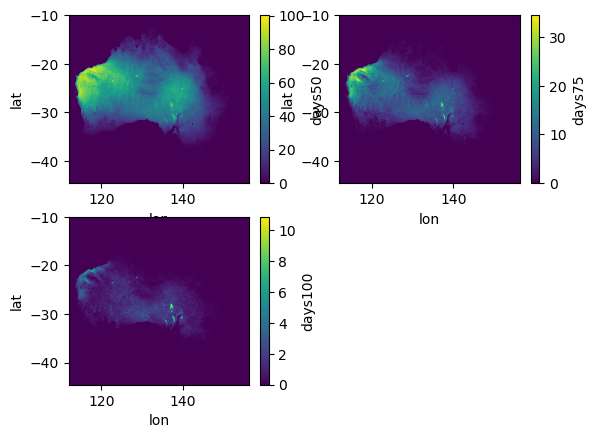

In [16]:
plt.subplot(2,2,1); d4.days50.plot()
plt.subplot(2,2,2); d4.days75.plot()
plt.subplot(2,2,3); d4.days100.plot()

In [ ]:
for mindex, file in enumerate(mRuns):
    print(file)

    
#    process_GWL_levels(model_name, model, ensemble, pathway, ffdi_data)

print("Processing of all catalogues is complete.")
client.close()

In [16]:
client.close()